In [1]:
!pip install -q feedparser tiktoken sentence-transformers chromadb langchain datasets transformers torch matplotlib seaborn scikit-learn pandas evaluate accelerate


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Modelo 1

In [29]:
from datasets import load_dataset
dataset = load_dataset("ag_news")
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [30]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset

df = pd.DataFrame(dataset["train"]).sample(frac=0.05, random_state=42).reset_index(drop=True)

train_full, test_df = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_full, test_size=0.1765, stratify=train_full["label"], random_state=42)

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)


In [31]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_tok = train_ds.map(tokenize_fn, batched=True)
val_tok = val_ds.map(tokenize_fn, batched=True)
test_tok = test_ds.map(tokenize_fn, batched=True)


Map:   0%|          | 0/4199 [00:00<?, ? examples/s]

Map:   0%|          | 0/901 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

In [32]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate

metric_f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"f1": metric_f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]}

training_args = TrainingArguments(
    output_dir="./roberta_agnews",
    eval_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir="./logs",
    logging_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipython-input-2434311228.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.439800,0.278333,0.914012
2,0.226900,0.299333,0.912851


TrainOutput(global_step=526, training_loss=0.33335231737492205, metrics={'train_runtime': 250.3352, 'train_samples_per_second': 33.547, 'train_steps_per_second': 2.101, 'total_flos': 552411580311552.0, 'train_loss': 0.33335231737492205, 'epoch': 2.0})

In [34]:
metrics_roberta = trainer.evaluate(test_tok)
print("RoBERTa:", metrics_roberta)


RoBERTa: {'eval_loss': 0.3515194058418274, 'eval_f1': 0.8916616386777563, 'eval_runtime': 5.94, 'eval_samples_per_second': 151.515, 'eval_steps_per_second': 9.596, 'epoch': 2.0}



# Modelo 2

In [35]:
from datasets import load_dataset
dataset = load_dataset("ag_news")
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [36]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset

df = pd.DataFrame(dataset["train"]).sample(frac=0.05, random_state=42).reset_index(drop=True)

train_full, test_df = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_full, test_size=0.1765, stratify=train_full["label"], random_state=42)

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)


In [37]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_tok = train_ds.map(tokenize_fn, batched=True)
val_tok = val_ds.map(tokenize_fn, batched=True)
test_tok = test_ds.map(tokenize_fn, batched=True)


Map:   0%|          | 0/4199 [00:00<?, ? examples/s]

Map:   0%|          | 0/901 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

In [38]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=4)


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate

metric_f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"f1": metric_f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]}

training_args = TrainingArguments(
    output_dir="./deberta_agnews",
    eval_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir="./logs",
    logging_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipython-input-3244106783.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,F1
1,0.419900,0.301861,0.905745
2,0.219900,0.304200,0.916465


TrainOutput(global_step=526, training_loss=0.3198686752029245, metrics={'train_runtime': 344.0906, 'train_samples_per_second': 24.406, 'train_steps_per_second': 1.529, 'total_flos': 643711579170816.0, 'train_loss': 0.3198686752029245, 'epoch': 2.0})

In [40]:
metrics_deberta = trainer.evaluate(test_tok)
print("DeBERTa:", metrics_deberta)

DeBERTa: {'eval_loss': 0.34802955389022827, 'eval_f1': 0.907471301395936, 'eval_runtime': 8.1287, 'eval_samples_per_second': 110.718, 'eval_steps_per_second': 7.012, 'epoch': 2.0}


# Modelo 3

In [41]:
from datasets import load_dataset
dataset = load_dataset("ag_news")
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [42]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset

df = pd.DataFrame(dataset["train"]).sample(frac=0.05, random_state=42).reset_index(drop=True)

train_full, test_df = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_full, test_size=0.1765, stratify=train_full["label"], random_state=42)

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)


In [43]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("answerdotai/modernbert-base")

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_tok = train_ds.map(tokenize_fn, batched=True)
val_tok = val_ds.map(tokenize_fn, batched=True)
test_tok = test_ds.map(tokenize_fn, batched=True)


Map:   0%|          | 0/4199 [00:00<?, ? examples/s]

Map:   0%|          | 0/901 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

In [44]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("answerdotai/modernbert-base", num_labels=4)


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/modernbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate

metric_f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"f1": metric_f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]}

training_args = TrainingArguments(
    output_dir="./modernbert_agnews",
    eval_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir="./logs",
    logging_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipython-input-1378187397.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,F1
1,0.384300,0.244875,0.918371
2,0.126400,0.327026,0.920678


TrainOutput(global_step=526, training_loss=0.255329596225753, metrics={'train_runtime': 385.3107, 'train_samples_per_second': 21.795, 'train_steps_per_second': 1.365, 'total_flos': 715431017293824.0, 'train_loss': 0.255329596225753, 'epoch': 2.0})

In [46]:
metrics_modernbert = trainer.evaluate(test_tok)
print("ModernBERT:", metrics_modernbert)


ModernBERT: {'eval_loss': 0.38215047121047974, 'eval_f1': 0.9151333195117004, 'eval_runtime': 9.0221, 'eval_samples_per_second': 99.756, 'eval_steps_per_second': 6.318, 'epoch': 2.0}


# Gráfico

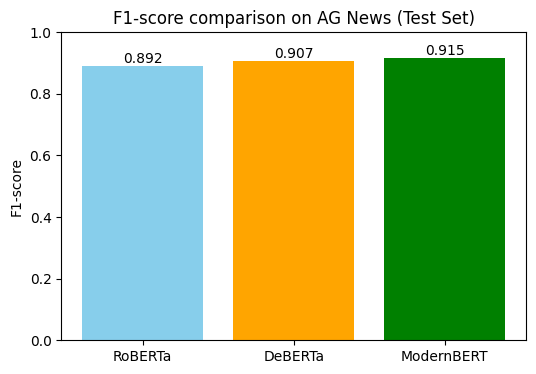

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

results = pd.DataFrame({
    "Model": ["RoBERTa", "DeBERTa", "ModernBERT"],
    "F1-score": [
        metrics_roberta["eval_f1"],
        metrics_deberta["eval_f1"],
        metrics_modernbert["eval_f1"]
    ]
})

plt.figure(figsize=(6,4))
plt.bar(results["Model"], results["F1-score"], color=["skyblue", "orange", "green"])
plt.title("F1-score comparison on AG News (Test Set)")
plt.ylabel("F1-score")
plt.ylim(0, 1)
for i, v in enumerate(results["F1-score"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=10)
plt.show()


### Comparación de modelos

Entre los tres modelos evaluados, ModernBERT obtuvo el mejor desempeño general, seguido de DeBERTa y RoBERTa.

El mejor resultado de ModernBERT sugiere que, para este conjunto de datos (AG News), su arquitectura optimizada y entrenamiento masivo sobre texto generalizado logran una mayor capacidad de generalización en tareas de clasificación de noticias.

Por otro lado, DeBERTa mostró un rendimiento muy competitivo con menor tiempo de ejecución, lo que evidencia su eficiencia computacional y buen equilibrio entre velocidad y precisión.  
RoBERTa, aunque ligeramente por debajo en F1, mantiene un rendimiento sólido gracias a su atención desagregada, pero podría necesitar más epochs o ajuste fino para superar a ModernBERT.

En conjunto, los tres modelos confirman la efectividad de las arquitecturas basadas en transformadores, con ModernBERT destacando como el modelo más preciso y RoBERTa como el más eficiente.

# Bonus

In [48]:
import feedparser
import pandas as pd


# URL del RSS de RPP
rss_url = "https://rpp.pe/rss"

feed = feedparser.parse(rss_url)

# Se extrae las 50 noticias más recientes
news_items = []
for entry in feed.entries[:50]:
    news_items.append({
        "title": entry.title,
        "description": entry.description,
        "link": entry.link,
        "date_published": entry.published if "published" in entry else None
    })

df_rpp = pd.DataFrame(news_items)
print(f"Noticias extraídas: {len(df_rpp)}")

Noticias extraídas: 50


In [49]:
from transformers import pipeline
import pandas as pd

# Definir las categorías de AG News
categories = ["World", "Sports", "Business", "Sci/Tech"]

# Cargar el modelo de clasificación zero-shot
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Clasificar cada noticia usando título + descripción
predictions = []
for i, row in df_rpp.iterrows():
    text = f"{row['title']}. {row['description']}"
    result = classifier(text, candidate_labels=categories)
    predicted_category = result["labels"][0]  # categoría con mayor score
    predictions.append(predicted_category)

# Agregar resultados al DataFrame
df_rpp["category_llm"] = predictions

# Guardar las clasificaciones en un nuevo JSON
df_rpp.to_json("rpp_llm_classified.json", orient="records", force_ascii=False, indent=4)

print("✅ Clasificación completada y guardada en 'rpp_llm_classified.json'")

Device set to use cuda:0


✅ Clasificación completada y guardada en 'rpp_llm_classified.json'


In [50]:
import pandas as pd

df_llm = pd.read_json("rpp_llm_classified.json")
df_llm.head()

,title,description,link,date_published,category_llm
0,"Mitsui Automotriz apunta vender 8,500 Toyota y...",Mitsui Automotriz proyecta un sólido crecimien...,https://rpp.pe/economia/economia/mitsui-automo...,"Thu, 23 Oct 2025 18:00:30 -0500",Business
1,"Temblor en Perú, hoy 23 de octubre: magnitud y...",Actualización EN VIVO del último sismo en Perú...,https://rpp.pe/lima/desastres-naturales/temblo...,"Wed, 22 Oct 2025 02:18:58 -0500",Sci/Tech
2,Sin velos y con escotes: video filtrado de bod...,La filtración de un video de la boda de Setaye...,https://rpp.pe/mundo/actualidad/video-filtrado...,"Thu, 23 Oct 2025 17:50:57 -0500",World
3,Nicolás Maduro anuncia nuevos ejercicios milit...,Maduro sostuvo que a la medianoche de este jue...,https://rpp.pe/mundo/actualidad/nicolas-maduro...,"Thu, 23 Oct 2025 17:47:59 -0500",World
4,Latin Billboard 2025: lista completa de nomina...,"En esta edición, Bad Bunny encabeza las nomina...",https://rpp.pe/musica/internacional/latin-bill...,"Thu, 23 Oct 2025 17:45:15 -0500",Business


In [63]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

#Roberta

model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained("/content/roberta_agnews/checkpoint-263", local_files_only=True)

def predict_category(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_label = torch.argmax(logits, dim=1).item()
    label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
    return label_map[predicted_label]

df_llm["pred_roberta"] = df_llm["title"].astype(str) + ". " + df_llm["description"].astype(str)
df_llm["pred_roberta"] = df_llm["pred_roberta"].apply(predict_category)

#Deberta

model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained("/content/deberta_agnews/checkpoint-526", local_files_only=True)

def predict_category(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_label = torch.argmax(logits, dim=1).item()
    label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
    return label_map[predicted_label]

df_llm["pred_deberta"] = df_llm["title"].astype(str) + ". " + df_llm["description"].astype(str)
df_llm["pred_deberta"] = df_llm["pred_deberta"].apply(predict_category)

#Mordernbert

model_name = "answerdotai/modernbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained("/content/modernbert_agnews/checkpoint-526", local_files_only=True)

def predict_category(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_label = torch.argmax(logits, dim=1).item()
    label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
    return label_map[predicted_label]

df_llm["pred_modernbert"] = df_llm["title"].astype(str) + ". " + df_llm["description"].astype(str)
df_llm["pred_modernbert"] = df_llm["pred_modernbert"].apply(predict_category)



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


🔹 pred_roberta — F1: 0.393 | Accuracy: 0.520
🔹 pred_deberta — F1: 0.481 | Accuracy: 0.620
🔹 pred_modernbert — F1: 0.381 | Accuracy: 0.520


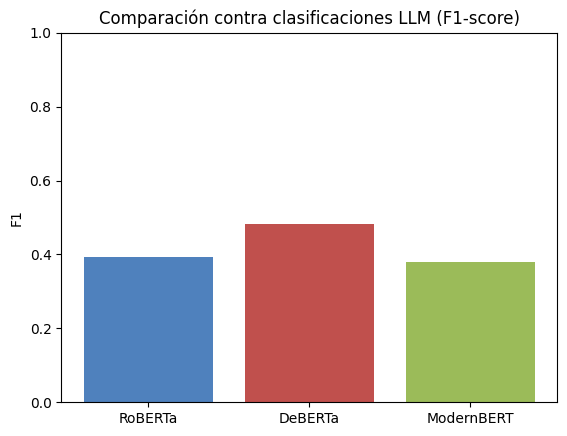

In [68]:
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

# Función para evaluar y devolver métricas
def evaluate_against_llm(df, model_col):
    y_true = df["category_llm"]
    y_pred = df[model_col]
    f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    print(f"🔹 {model_col} — F1: {f1:.3f} | Accuracy: {acc:.3f}")
    return f1, acc

# Evaluar y guardar automáticamente
f1_roberta, _ = evaluate_against_llm(df_llm, "pred_roberta")
f1_deberta, _ = evaluate_against_llm(df_llm, "pred_deberta")
f1_modernbert, _ = evaluate_against_llm(df_llm, "pred_modernbert")

# Crear diccionario de resultados reales
scores = {
    "RoBERTa": f1_roberta,
    "DeBERTa": f1_deberta,
    "ModernBERT": f1_modernbert
}

# Gráfico
plt.bar(scores.keys(), scores.values(), color=['#4F81BD', '#C0504D', '#9BBB59'])
plt.title("Comparación contra clasificaciones LLM (F1-score)")
plt.ylabel("F1")
plt.ylim(0, 1)
plt.show()

### Discusión

Las predicciones de los modelos muestran cierta variación en su consistencia con la clasificación del LLM. Entre ellos, **DeBERTa** es el que mejor se alinea, alcanzando el mayor F1  y precisión. Esto sugiere que su arquitectura y capacidad para comprender mejor el contexto le permiten capturar patrones más sutiles en el texto en comparación con RoBERTa y ModernBERT. Las discrepancias pueden deberse a diferencias en el **entrenamiento previo**, la **longitud del contexto** y el **diseño del modelo**, factores que influyen en su capacidad de generalización frente a los datos etiquetados por el LLM.
